<a href="https://colab.research.google.com/github/Kseniya74/Prof_activity_workshop/blob/main/Text_processing_fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Классификация фейковых новостей**

##**Иморт необходимых библиотек**

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
nltk.download('stopwords')   # Скачивание стоп-слов
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import pathlib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##**Загрузка датасета**

In [56]:
#  Монтирование диска с датасетом

from google.colab import drive
drive.mount('/content/gdrive')

data_dir = "/content/gdrive/MyDrive"
data_dir = pathlib.Path(data_dir)
data_dir

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


PosixPath('/content/gdrive/MyDrive')

In [57]:
true = pd.read_csv("/content/gdrive/MyDrive/Практикум/TextProcessing/True.csv")
false = pd.read_csv("/content/gdrive/MyDrive/Практикум/TextProcessing/Fake.csv")

##**Визуализация и предобработка данных**

In [58]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [59]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [60]:
true['category'] = 1
false['category'] = 0

In [61]:
df = pd.concat([true,false]) # Объединение двух датасетов

In [105]:
df

,text,category
0,WASHINGTON (Reuters) head conservative Republi...,1
1,WASHINGTON (Reuters) Transgender people allowe...,1
2,WASHINGTON (Reuters) special counsel investiga...,1
3,WASHINGTON (Reuters) Trump campaign adviser Ge...,1
4,SEATTLE/WASHINGTON (Reuters) President Donald ...,1
...,...,...
23476,21st Century Wire says 21WIRE reported earlier...,0
23477,21st Century Wire says familiar theme. Wheneve...,0
23478,Patrick Henningsen 21st Century WireRemember O...,0
23479,21st Century Wire says Al Jazeera America go h...,0


In [63]:
df.isna().sum() # Проверка, есть ли пропуски

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [64]:
df.title.count()

44898

In [65]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

**Добавление всех текстовых данных в одну колонку, например, 'text'**

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

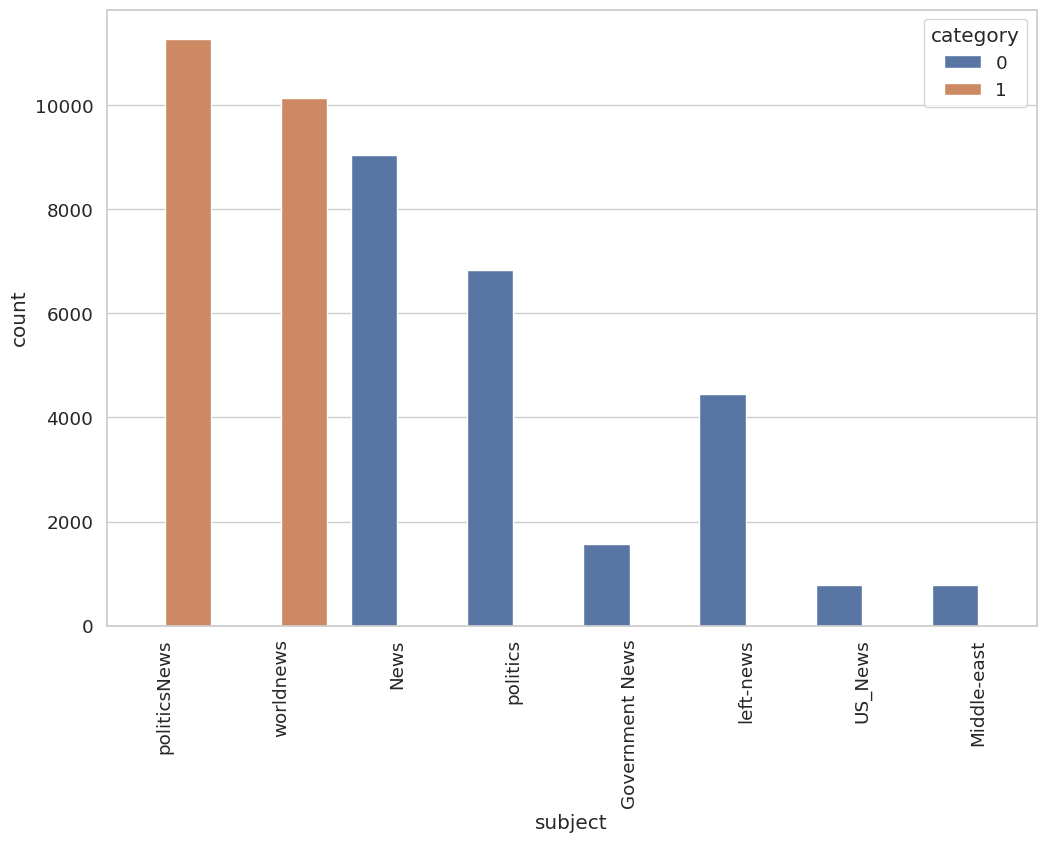

In [66]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

**Так как темы в столбце 'subject' разные для обеих категорий, удаляем его**

In [67]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

**Стоп-слова – это английские слова, которые не придают предложению особого смысла. Их можно смело игнорировать, не жертвуя смыслом предложения. Например, такие слова, как the, he, have и т. д. Загружаем список таких слов в Python.**

In [68]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

##**Чистка данных**

In [69]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Убираем квадратные скобки
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Убираем ссылки
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

# Убираем стоп-слова
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

# Убираем текст с шумами
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

# Применяем функцию для чистки колонки
df['text']=df['text'].apply(denoise_text)

<ipython-input-69-b169dabb7d22>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


###**Облако слов для настоящих новостей**

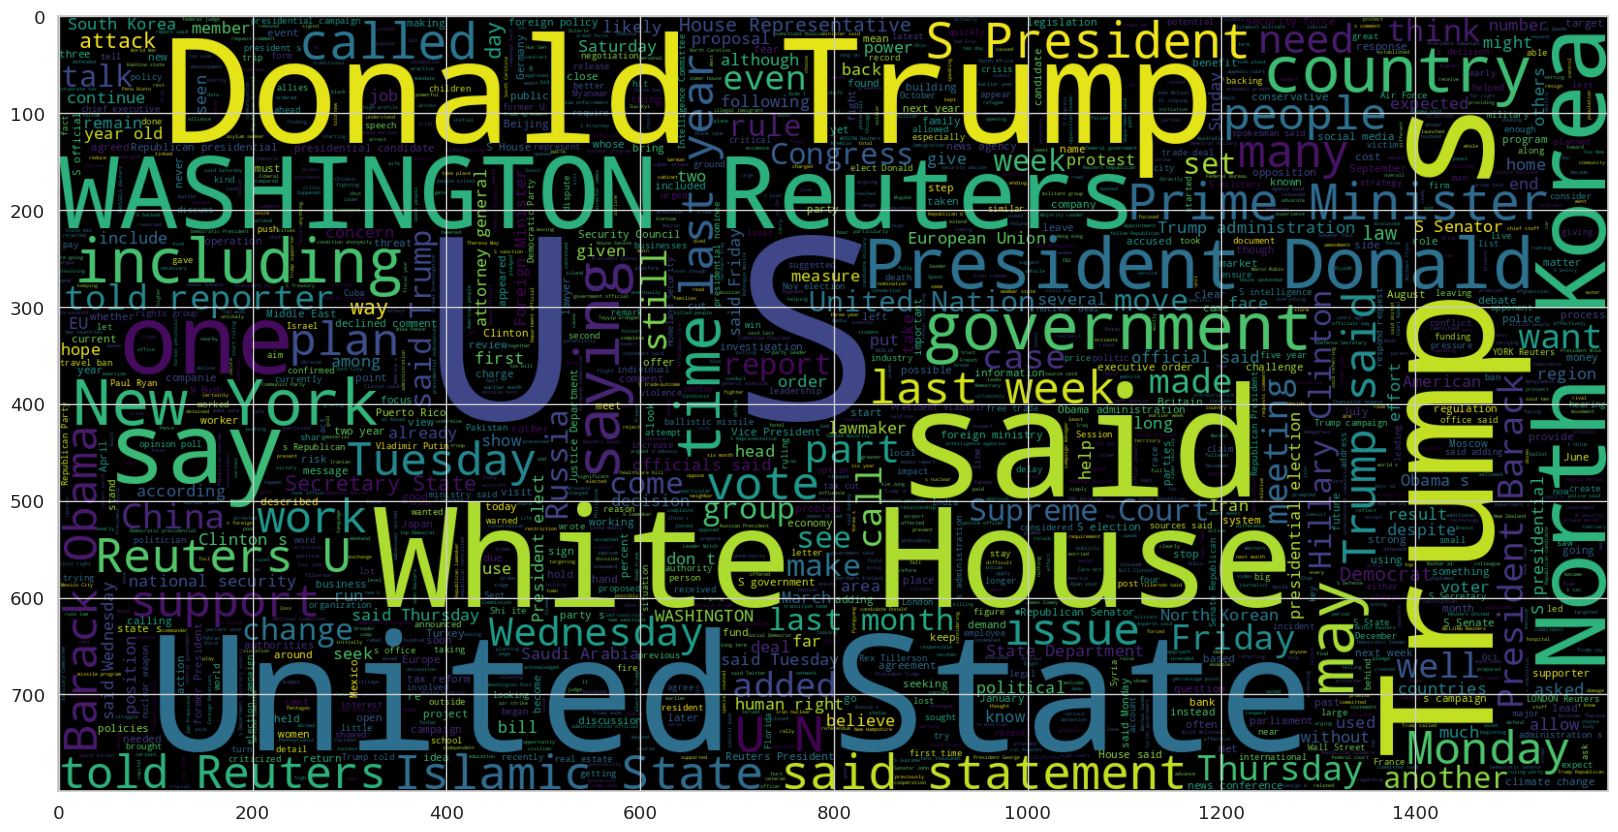

In [70]:
plt.figure(figsize = (20,20)) # Слова из обычных новостей
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

###**Облако слов для фейковых новостей**

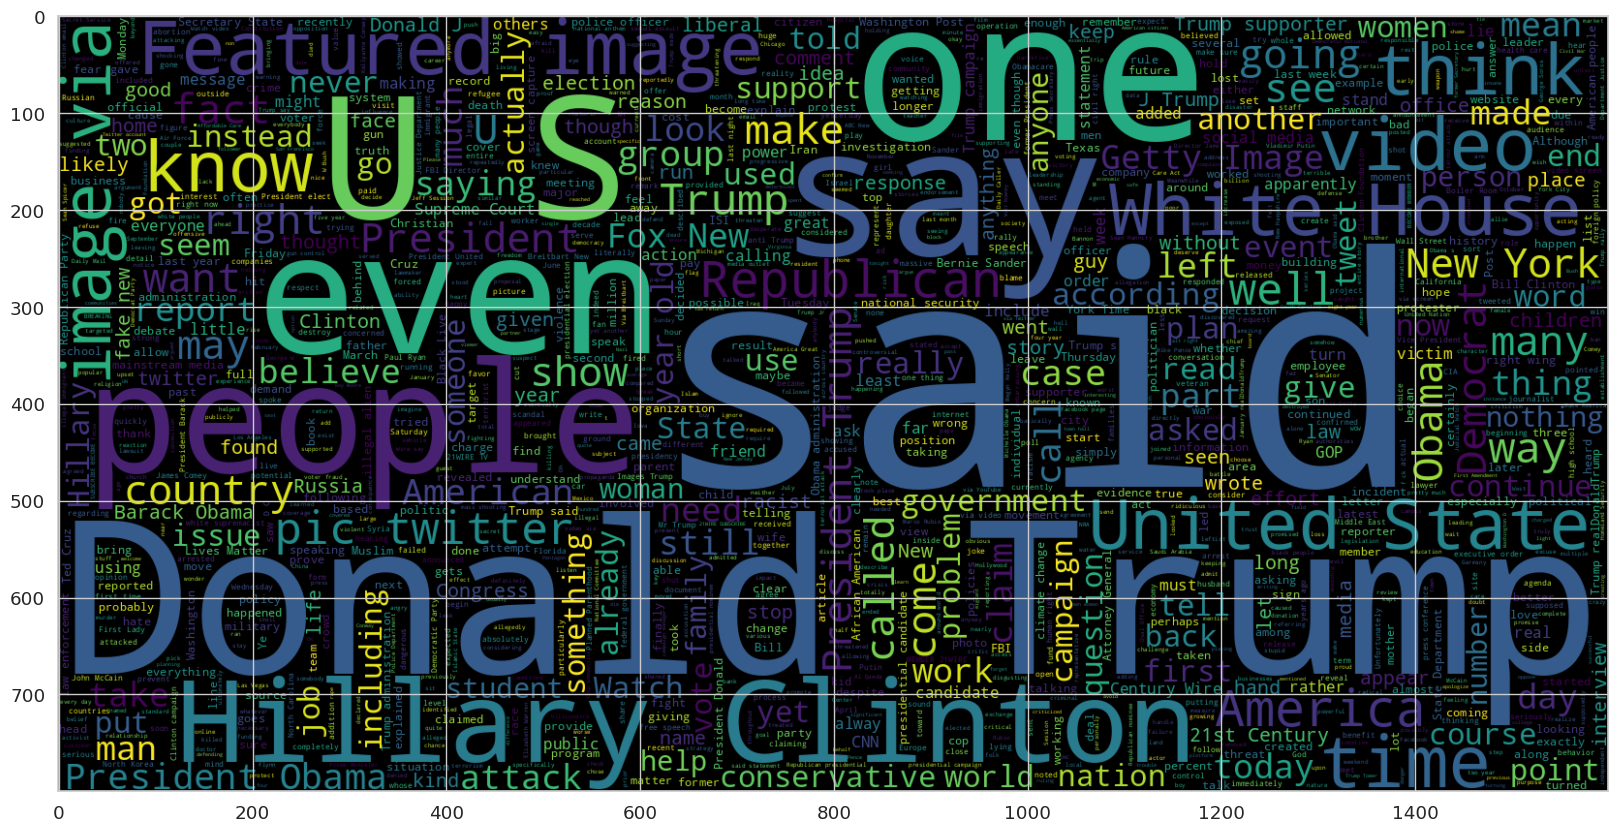

In [71]:
plt.figure(figsize = (20,20)) # Слова для фейковых новостей
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

###**Количество символов в обычных и фейковых новостях**

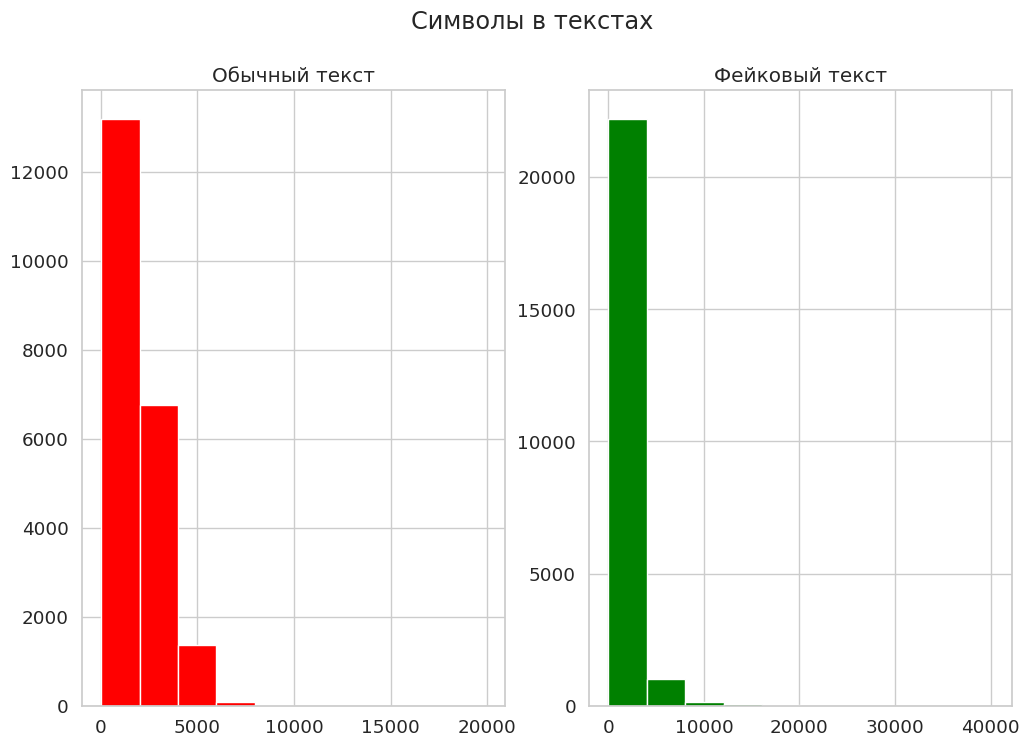

In [72]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Обычный текст')
text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Фейковый текст')
fig.suptitle('Символы в текстах')
plt.show()

**Здесь мы можем наблюдать немного отличное распределение. Текст длиной 2500 символов является наиболее распространенным в категории обычных новостей, а текст длиной около 5000 символов чаще всего встречается в категории фейковых новостей**

###**Количество слов в обычных и фейковых новостях**

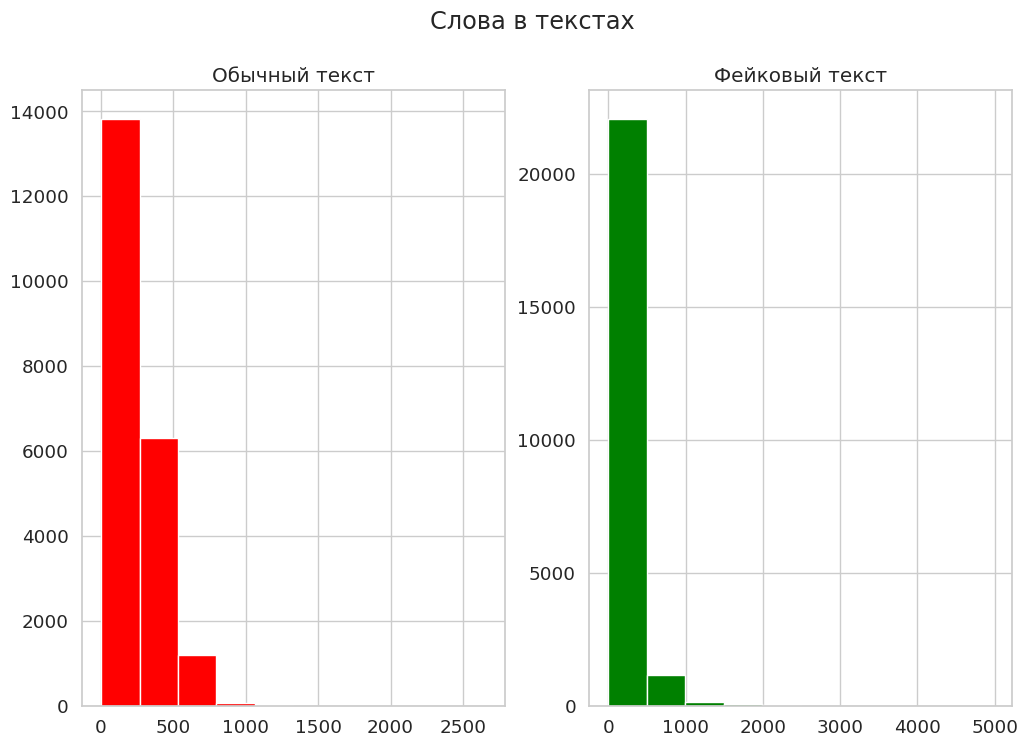

In [73]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Обычный текст')
text_len=df[df['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Фейковый текст')
fig.suptitle('Слова в текстах')
plt.show()

###**Средняя длина слов в обычных и фейковых новостях**

<ipython-input-74-287c34a471a2>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-74-287c34a471a2>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level f

Text(0.5, 0.98, 'Средняя длина слов в каждом тексте')

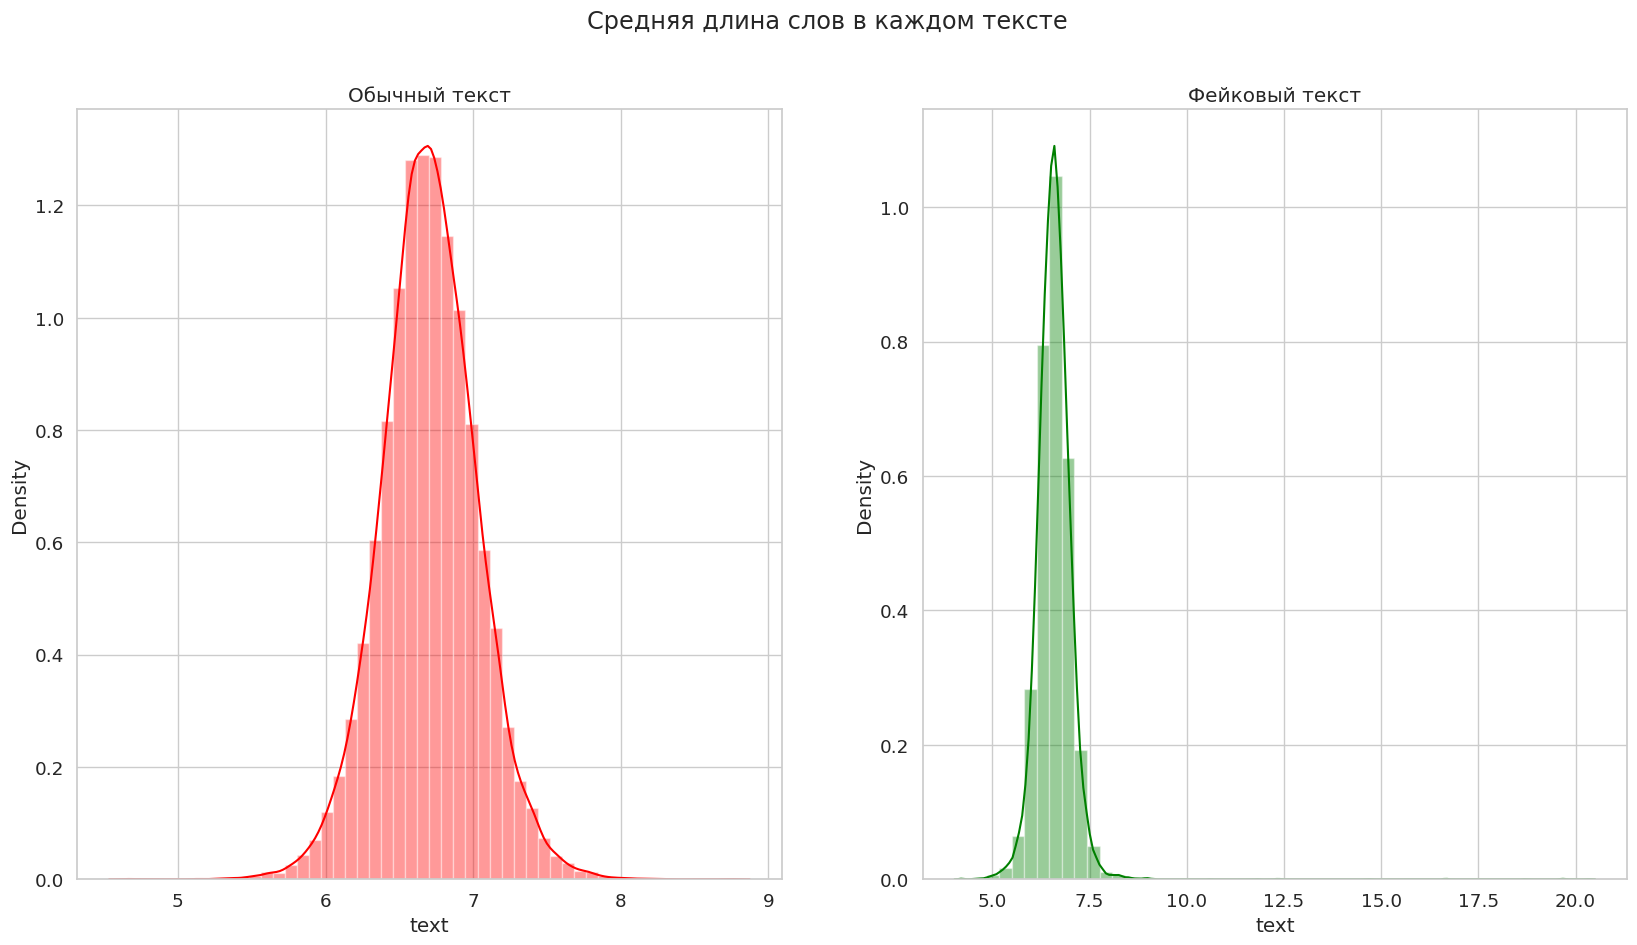

In [74]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Обычный текст')
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Фейковый текст')
fig.suptitle('Средняя длина слов в каждом тексте')

In [106]:
# Создаём список всех слов из датасета (корпус)

def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:15]

['WASHINGTON',
 '(Reuters)',
 'head',
 'conservative',
 'Republican',
 'faction',
 'U.S.',
 'Congress,',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'pay']

In [113]:
# Подсчёт частоты слов

from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Trump': 111503,
 'said': 93162,
 'would': 54613,
 'U.S.': 50441,
 'President': 33180,
 'people': 33115,
 'also': 30325,
 'one': 29370,
 'Donald': 27795,
 'said.': 26194}

In [119]:
from sklearn.feature_extraction.text import CountVectorizer

# Функция для выделения наиболее часто встречающихся n-грамм (последовательностей из n слов)
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus) # матрица токенов (строки представляют собой тексты, а столбцы - токены (слова))
    sum_words = bag_of_words.sum(axis=0) # сумма количества вхождений каждого токена
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] # список кортежей, где каждый кортеж содержит слово и его частоту встречаемости в корпусе
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) # сортировка списка кортежей по убыванию частоты

    return words_freq[:n] # топ n наиболее часто встречающихся n-грамм в виде списка кортежей, где каждый кортеж содержит слово и его частоту встречаемости

**Строим график для топ-10 одиночных слов**

<Axes: >

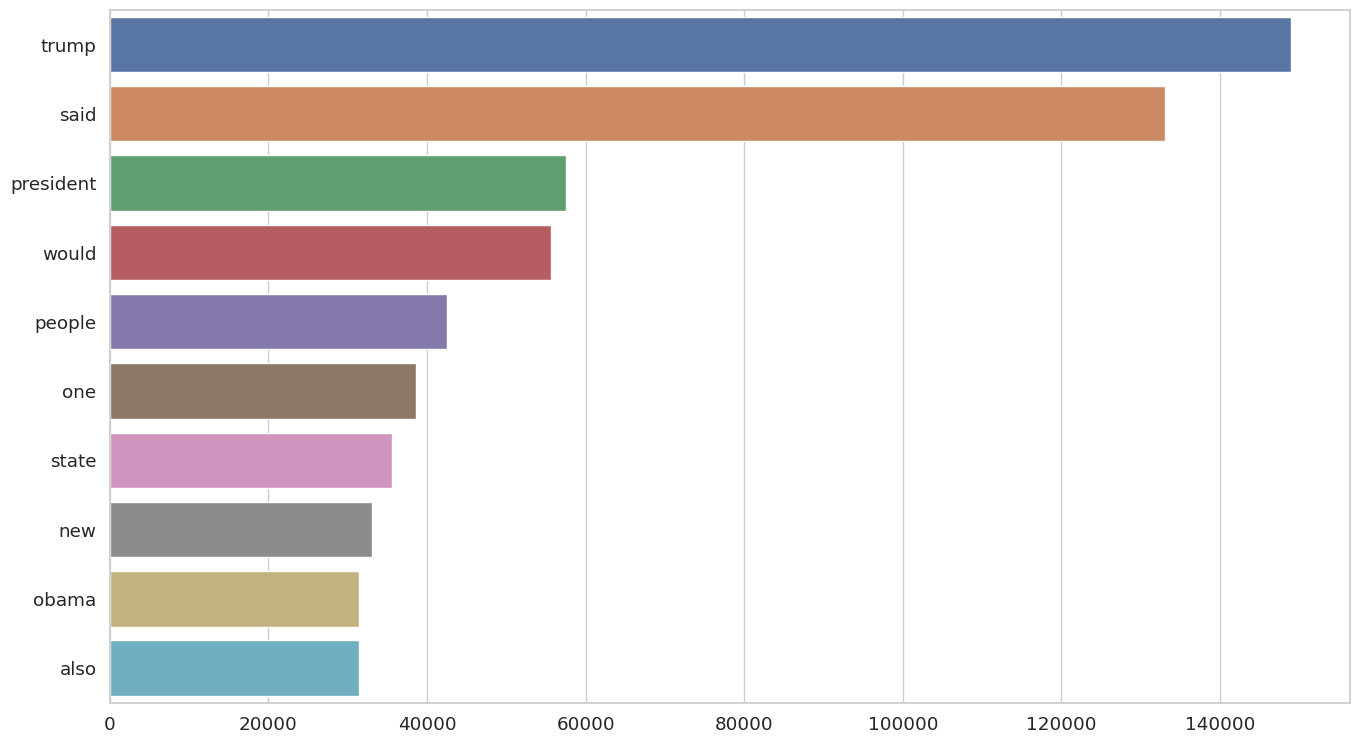

In [78]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

**Строим график для топ-10 последовательностей двух соседних слов**

<Axes: >

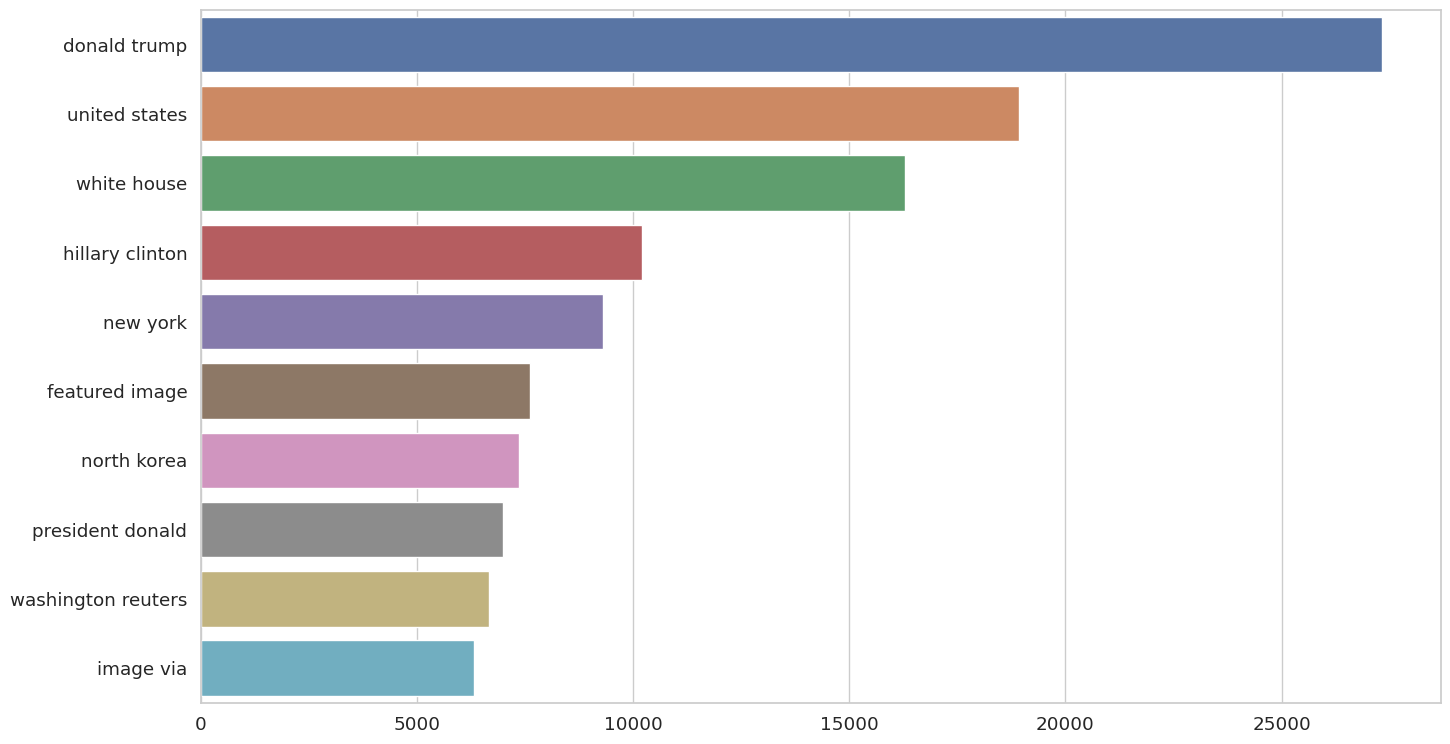

In [79]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

**Строим график для топ-10 последовательностей трёх соседних слов**

<Axes: >

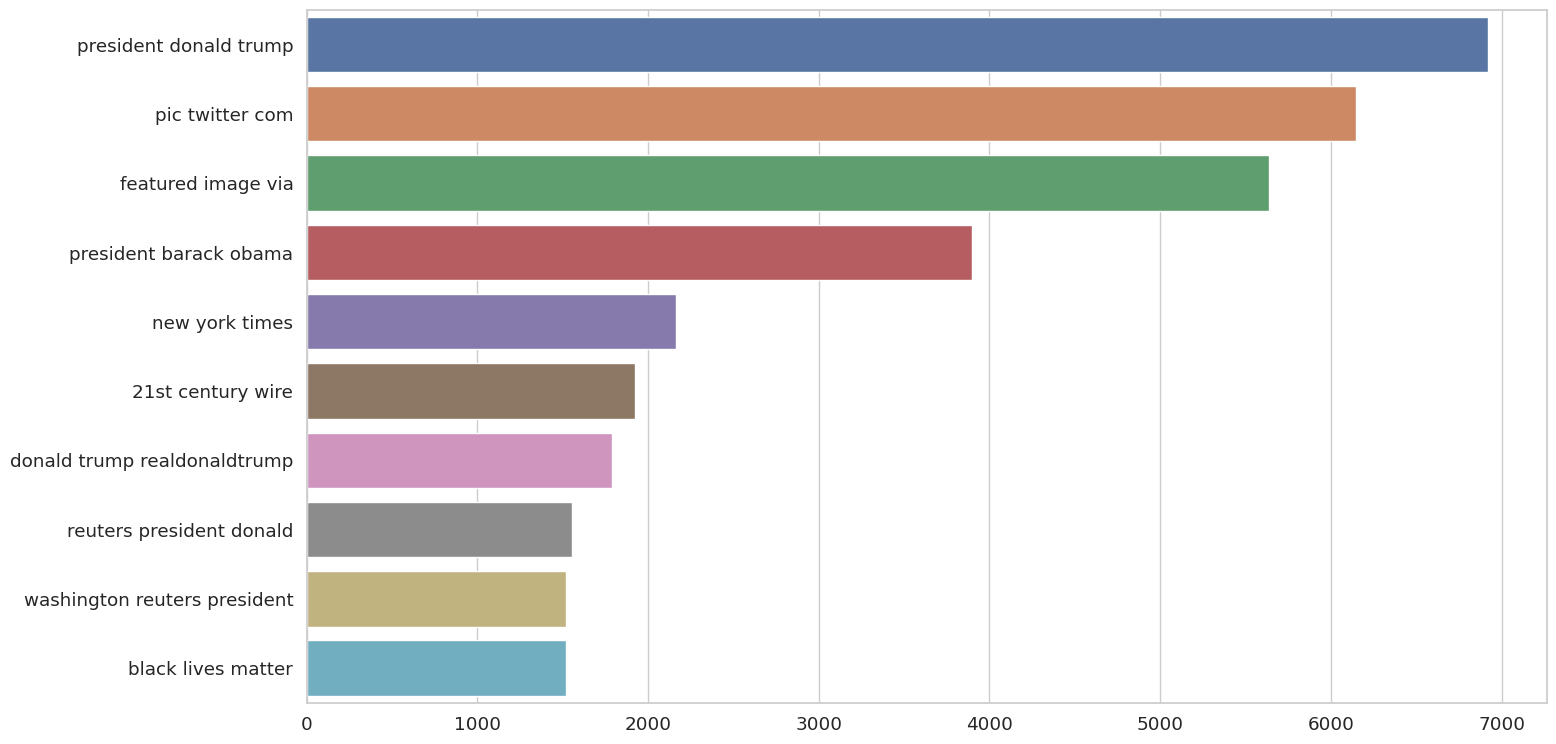

In [80]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

###**Разделяем данные на тренировочные и тестовые данные**

In [81]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [82]:
max_features = 10000 # максимальное количество уникальных слов
maxlen = 300

**Токенизация текста — это представление каждого слова числовым значением.**

**Сопоставление исходного слова с числом сохраняется в свойстве word_index токенизатора.**

**Tokenizer применяет базовую обработку, например, меняет текущий регистр на нижний, явно устанавливая для него значение False.**

**Сохраним число всех новостей длиной до 300, добавим отступы к новостям, содержащим менее 300 слов, и обрежем длинные.**

In [83]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train) # строим словарь слов и их индексов на основе тренировочных данных
tokenized_train = tokenizer.texts_to_sequences(x_train) # преобразуем тексты из тренировочного набора в последовательности числовых индексов
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)  # дополнение последовательностей числовых индексов до заданной максимальной длины.
                                                                  # Если последовательность короче, она заполняется нулями в начале, а если длиннее, она обрезается

In [84]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

**Благодаря методу GloVe из матрицы совпадений можно вывести семантические отношения между словами.**

In [85]:
EMBEDDING_FILE = '/content/gdrive/MyDrive/Практикум/TextProcessing/glove.twitter.27B.100d.txt'

In [115]:
# Функция, которая создаёт словарь, где ключ - это слово, а значение - его вектор

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [116]:
# Создание матрицы весов для Embedding слоя модели, где каждой строке соответствует вектор слова

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


###**Устанавливаем параметры обучения модели**

In [88]:
batch_size = 64
epochs = 5
embed_size = 100

##**Обучение модели**

In [89]:
model = Sequential()

model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False)) # Преобразует входные индексы слов в векторы заданной размерности

model.add(LSTM(units=128, return_sequences = True, recurrent_dropout = 0.25, dropout = 0.25)) # Обрабатывает последовательность входных данных с учетом долгосрочных зависимостей
model.add(LSTM(units=64, recurrent_dropout = 0.1, dropout = 0.1))

model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [90]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm_2 (LSTM)               (None, 300, 128)          117248    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1168769 (4.46 MB)
Trainable params: 168769 (659.25 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________


In [91]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)

Epoch 1/5
66/66 [==============================] - 140s 2s/step - loss: 0.2753 - accuracy: 0.8871 - val_loss: 0.1331 - val_accuracy: 0.9528 - lr: 0.0010
Epoch 2/5
66/66 [==============================] - 154s 2s/step - loss: 0.1197 - accuracy: 0.9563 - val_loss: 0.1215 - val_accuracy: 0.9578 - lr: 0.0010
Epoch 3/5
66/66 [==============================] - 136s 2s/step - loss: 0.0891 - accuracy: 0.9681 - val_loss: 0.0591 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 4/5
66/66 [==============================] - 132s 2s/step - loss: 0.0506 - accuracy: 0.9824 - val_loss: 0.0412 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 5/5
66/66 [==============================] - 133s 2s/step - loss: 0.0368 - accuracy: 0.9868 - val_loss: 0.0261 - val_accuracy: 0.9916 - lr: 0.0010


##**Оценка модели**

In [92]:
print("Точность тренировочной модели - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Точность тестовой модели - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 190s 180ms/step - loss: 0.0194 - accuracy: 0.9934
Точность тренировочной модели -  99.34071898460388 %
351/351 [==============================] - 63s 180ms/step - loss: 0.0261 - accuracy: 0.9916
Точность тестовой модели -  99.16258454322815 %


##**Тестирование на валидационных данных**

In [112]:
# Тестирование модели на валидационной выборке

def preprocess_text(text):
    text = denoise_text(text)
    tokenized_text = tokenizer.texts_to_sequences([text])
    padded_text = sequence.pad_sequences(tokenized_text, maxlen=maxlen)
    return padded_text

def predict_fake_news(texts):
    predictions = []
    for text in texts:
        preprocessed_text = preprocess_text(text)
        prediction = model.predict(preprocessed_text)
        predictions.append(prediction[0, 0])
    return predictions

# Генерируем несколько новостей

news_texts = [
    "Donald Trump's current deputy national security adviser K.T. McFarland, a former Fox News personality, K. T. McFarland admitted in an email to a colleague during the 2016 presidential transition to Russia throwing the election to Trump. The leaked email was written just weeks before Trump's inauguration and it states that sanctions would make it difficult to ease relations with Russia, which has just thrown the U.S.A. election to him. The New York Times reports:But emails among top transition officials, provided or described to The New York Times, suggest that Mr. Flynn was far from a rogue actor. In fact, the emails, coupled with interviews and court documents filed on Friday, showed that Mr. Flynn was in close touch with other senior members of the Trump transition team both before and after he spoke with the Russian ambassador, Sergey I. Kislyak, about American sanctions against Russia.A White House lawyer tried to explain McFarland's email to the The Times by saying that she was referring to the Democrats' portrayal of the election. That doesn't make any sense, by the way.McFarland wrote the email to Thomas P. Bossert, who currently serves as Trump's homeland security adviser, then he forwarded it to future National Security Advisor Michael Flynn (now indicted), future Chief of Staff Reince Priebus, future senior strategist Stephen Bannon, and future press secretary Sean Spicer, the Daily Beast reports.With all the pearl-clutching we witnessed from conservatives about Hillary Clinton's emails, you'd think they wouldn't be sending messages about Russia throwing the election to Trump.This past March, John Oliver, the host of the HBO comedy show Last Week Tonight started a segment called 'Stupid Watergate,' which he described as 'a scandal with all the potential ramifications of Watergate, but where everyone involved is stupid and bad at everything. Nailed it!Photo by Chip Somodevilla/Getty Images.",
    "WASHINGTON (Reuters) - In a significant development, it has been revealed that George Papadopoulos, a Trump campaign adviser, shared information with Australian diplomat Alexander Downer in May 2016 regarding Russia possessing political information on Democratic presidential candidate Hillary Clinton. According to a report by the New York Times on Saturday, this conversation in London played a crucial role in prompting the FBI to initiate a counter-intelligence investigation into Moscow's interactions with the Trump campaign. The information provided by Papadopoulos reached Australian officials two months later, coinciding with the emergence of leaked Democratic emails online. The New York Times cited four current and former U.S. and foreign officials for this revelation. Aside from Australian intelligence, the Federal Bureau of Investigation's inquiry also drew on information from other allied nations, including the British and Dutch governments. George Papadopoulos, an international energy lawyer based in Chicago, pleaded guilty on October 30 to lying to FBI agents about his contacts with individuals claiming ties to high-ranking Russian officials. This marked the first criminal charge connecting the Trump campaign to Russia. Although the White House has downplayed Papadopoulos' role, asserting it was extremely limited and any actions were his own, the New York Times reported that he facilitated a meeting between then-candidate Donald Trump and Egyptian President Abdel Fattah al-Sisi. Papadopoulos also played a role in editing the outline of Trump's inaugural major foreign policy speech in April 2016. The ongoing federal investigation, now led by Special Counsel Robert Mueller, has cast a shadow over Trump's presidency since he assumed office nearly a year ago. Recent claims by some Trump allies allege bias within Mueller's team against the Republican president. Lawyers representing Papadopoulos have not responded to Reuters' requests for comment, and Mueller's office declined to provide a statement. Ty Cobb, Trump's White House attorney, refrained from commenting on the New York Times report, stating, Out of respect for the special counsel and his process, we are not commenting on matters such as this. Mueller has brought charges against four Trump associates, including Papadopoulos, in the course of his investigation. Russia has consistently denied interference in the U.S. election, and President Trump maintains that there was no collusion between his campaign and Moscow."
]

predictions = predict_fake_news(news_texts)

# Вывод результатов
for i, prediction in enumerate(predictions):
    if prediction >= 0.5:
        print(f"Новость {i + 1}: НЕ является фейковой.")
    else:
        print(f"Новость {i + 1}: Является фейковой.")

1/1 [==============================] - 0s 162ms/step
Новость 1: Является фейковой.
Новость 2: НЕ является фейковой.


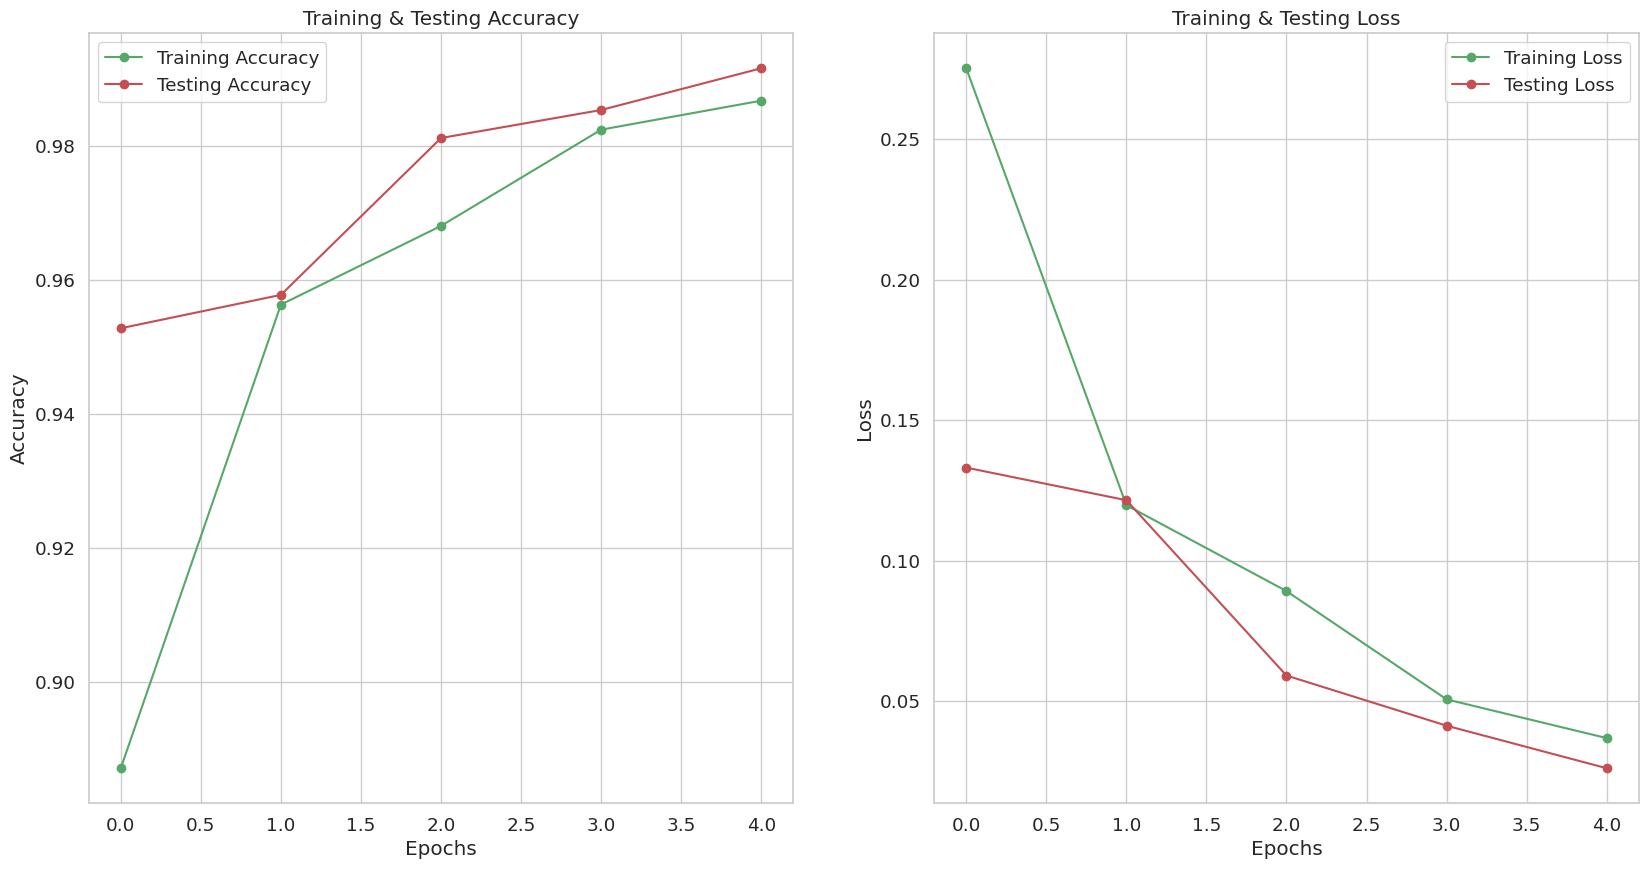

In [96]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()